In [18]:
import pandas as pd 
import numpy as np 
from scipy.signal import csd
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from numpy.linalg import inv
import itertools
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

In [2]:
covid_data= pd.read_csv("data/us.csv")
n_rows = len(covid_data)
daily_cases = covid_data["cases"].diff(7)
daily_deaths = covid_data["deaths"].diff(7)
covid_data["daily_cases"] = daily_cases
covid_data["daily_death"] = daily_deaths
covid_data = covid_data.fillna(0)
## replace initial NaN with 0 
# covid_data["daily_cases"][0] = 0 
# covid_data["daily_death"][0] = 0 


In [3]:
covid_data["deaths"][130] - covid_data["deaths"][129]

963

In [4]:
covid_data["daily_death"][130]

6715.0

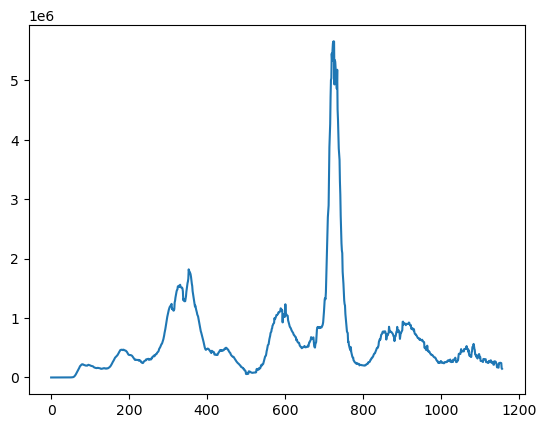

In [5]:
plt.plot(covid_data["daily_cases"])
#plt.plot(covid_data["deaths"])

In [6]:
have_ran = True 
def dateNum(date):
    m_day = datetime.date(2022,6,2)
    parts = date.split("-")
    day = datetime.date(int(parts[0]),int(parts[1]),int(parts[2]))
    return (m_day - day).days
if not have_ran:
    tweets = pd.read_csv("data/tweetid_userid_keyword_sentiments_emotions_United States.csv")
    tweets["emotion"] = tweets["emotion"].fillna("N")
    tweets_data = dict() 
    def convertor(x):
        if(x in [-2,-1,0,1,2]):
            return [-2,-1,0,1,2].index(x)
        elif(x in ["N", "S", "H", "A","F"]):
            return ["N", "S", "H", "A","F"].index(x)+5
        else:
            print("Oh no this shound't happen at ", x )
            

    for i in range(n_tweets):
        day = tweets["tweet_timestamp"][i].split(" ")[0]
        sent = tweets["sentiment"][i] 
        emote = tweets["emotion"][i] 
        if(day in tweets_data):
            tweets_data[day][convertor(sent)] += 1
            tweets_data[day][convertor(emote)] += 1
        else: 
            arr = [0 for i in range(10)]
            arr[convertor(sent)] = 1 
            arr[convertor(emote)] = 1
            tweets_data[day] = arr.copy() 
    n = len(tweets_data)
    dates = ["" for i in range(n)] 


    measurement = np.zeros((n, 10))

    for tweet in tweets_data:
        i = dateNum(tweet)
        measurement[i, :] = tweets_data[tweet]
        dates[i] = tweet 
    twitter_cleaned = pd.DataFrame(measurement,
                                columns=["-2_sent","-1_sent","0_sent",
                                            "1_sent","2_sent",
                                            "N", "S", "H", "A","F"] )
    twitter_cleaned.insert(0, "Date", dates)
    twitter_cleaned.to_csv("data/twitter_aggr.csv")
else: 
    twitter_data = pd.read_csv("data/twitter_aggr.csv")

In [7]:
emotions = ["N", "S", "H", "A", "F"]
sents = ["-2_sent", "-1_sent", "0_sent", "1_sent", "2_sent"]

In [12]:
def filter_foo(val, data):
    if(val > np.mean(data)):
        return 1 
    else: 
        return 0
    # if(val < np.quantile(data, 0.25)):
    #     return 1 
    # elif(val < np.quantile(data, 0.5)):
    #     return 2 
    # elif(val < np.quantile(data, 0.75)):
    #     return 3 
    # else:
    #     return 4

def average_sent(row):
    weights = [-2, -1, 0, 1, 2]
    labels = ["-2_sent", "-1_sent", "0_sent", "1_sent", "2_sent"]
    total = sum( weights[i]*row[labels[i]] for i in range(5))
    return round(total)
#keys =  {0 : "-2_sent", 1 : "-1_sent", 2 : "0_sent", 3 : "1_sent", 4 : "2_sent" 
 #        ,7 : "A", 8 : "H", 9 : "S", 10 : "N", 11 : "F"}
keys_emote = {0 : "A", 1 : "H", 2 : "S", 3 : "N", 4 : "F" }
keys_sent = {0 : "-2_sent", 1: "-1_sent", 2:"0_sent", 3:"1_sent", 4:"2_sent"}
n = len(keys_emote)+2
data = np.zeros((n,len(twitter_data["A"])))
emote_data =  np.zeros((n,len(twitter_data["A"])))
sent_data =  np.zeros((n,len(twitter_data["A"])))
emote_dis = np.zeros((n, len(twitter_data["A"])))
sent_dis = np.zeros((n, len(twitter_data["A"])))

totals = np.sum(twitter_data[["A","S","F","H","N"]], axis=1)
total_sent = [average_sent(twitter_data.iloc[i]) for i in range(len(twitter_data["A"]))][::-1]
for i in range(n):
    if(i==5):
        emote_data[i,:] = covid_data["daily_cases"][7:864]
        sent_data[i,:] = covid_data["daily_cases"][7:864]

        emote_dis[i,:] = [filter_foo(val,
                                covid_data["daily_cases"][7:864]) for val in covid_data["daily_cases"][7:864]]
        sent_dis[i,:] = [filter_foo(val,
                                covid_data["daily_cases"][7:864]) for val in covid_data["daily_cases"][7:864]]
        #emote_dis[i+7, :] = [filter_foo(val, covid_data["daily_cases"][7:864]) for val in covid_data["daily_cases"][7:864].rolling(7).sum().fillna(0)]

    elif(i==6):
        emote_data[i,:] = covid_data["daily_death"][7:864]
        sent_data[i,:] = covid_data["daily_death"][7:864]

        emote_dis[i,:] = [filter_foo(val,
                                covid_data["deaths"][7:864]) for val in covid_data["deaths"][7:864]]
        sent_dis[i,:] = [filter_foo(val,
                                covid_data["daily_death"][7:864]) for val in covid_data["daily_death"][7:864]]
        #remote_dis[i+7, :] = [filter_foo(val, covid_data["daily_death"][7:864]) for val in covid_data["daily_death"][7:864].rolling(7).sum().fillna(0)]

    #elif(i==7):
    #    emote_dis[i, :] = [filter_foo(val, covid_data["daily_cases"][7:864]) for val in covid_data["daily_cases"][7:864].rolling(3).sum().fillna(0)]
    #elif(i==8):
    else: 
        emote_data[i,:] = twitter_data[keys_emote[i]][::-1]
        sent_data[i,:] = twitter_data[keys_sent[i]][::-1]
        emote_dis[i,:] = [filter_foo(val,
                                twitter_data[keys_emote[i]]) for val in twitter_data[keys_emote[i]][::-1]]
        sent_dis[i,:] = [filter_foo(val,
                                twitter_data[keys_sent[i]]) for val in twitter_data[keys_sent[i]][::-1]]
        
        #emote_dis[i+7, :] = [filter_foo(val, twitter_data[keys_emote[i]]) for val in twitter_data[keys_emote[i]][::-1].rolling(7).sum().fillna(0)]


In [9]:
n = len(keys) + 2 
Pxys = np.zeros((n,n,129), dtype=np.complex64)
Pxy_max = np.zeros((n,n), dtype=np.complex64)
for i in range(n):
    for j in range(n):
        f, cxy = csd(emote_dis[i,:],data[j,:])
        Pxys[i,j,:] = cxy 



NameError: name 'keys' is not defined

In [10]:
def insert_diag(M):
    n = len(M)
    A = np.zeros((n+1,n+1), dtype=np.complex64)
    for i in range(n):
        for j in range(0,i):
            A[i,j] = M[i,j] 
        for j in range(i+1, n+1):
            A[i,j] = M[i, j-1]
    return A 
### 60 is an arbitrary frequency to check
def wiener_project(csd_data, freq=60):
    n = len(csd_data)
    result = np.zeros((n,n), dtype=complex)
    for i in range(n):
        mxx = np.zeros((n-1,n-1), dtype=np.complex64)
        c = 0 
        for j in range(n):
            if(j==i): continue
            d = 0
            for k in range(n):
                if(k==i): continue
                mxx[c,d] = csd_data[j,k,freq]
                d += 1
            c += 1 
        fil = [j for j in range(n) if j!=i]

        result[i, fil] =  csd_data[i,fil,freq] @ inv(mxx)
    return result



In [11]:
def adj(data, i, ex=-1):
    lst = []
    for j in range(6):
        if(j == ex or j == i):
            continue
        if(data[i,j] == 1):
            lst.append(j)
    return lst 

def max_adj(data):
    adjs = np.sum(data, axis=0)
    return np.max(adjs) 

def project(csd_data, data, i, subspace_idx,freq=45):
    n = len(subspace_idx)
    v =   csd_data[i, subspace_idx]
    M = np.zeros((n,n), np.complex64)
    for j in range(n):
        for k in range(n):
            M[j,k] = csd_data[subspace_idx[j], subspace_idx[k]]
    Minv = inv(M)
    return v @ Minv @ data[:, subspace_idx].T



def seps(csd_data, data , x : int ,y : int , subset : list ):
    xz = project(csd_data, data, x, subset)
    xyz = project(csd_data, data, x, [y] + subset )
    return np.linalg.norm( xyz - xz) < 350 ## not sure if it should be properly 0 or just small 

def pc1(csd_data,data): 
    n = len(data)
    G1 = np.ones((n,n)) - np.eye(n,n)
    seperators = {}
    depth = 0
    while(max_adj(G1) >= depth ): 
        for x in range(n):
            for y in range(n):
                if(G1[x,y] == 0): continue 
                if(sum(G1[x,:]) - 1 >= depth ): 
                    lst = adj(G1, x, y)
                    for s in itertools.combinations(lst, depth):
                        if(seps(csd_data,data, x, y, list(s))):
                            G1[x,y] = 0 
                            G1[y,x] = 0
                            seperators[(x,y)] = s
                            seperators[(y,x)] = s
        depth = depth + 1 
    ### using 2 for later parts to denote the edge is of an undirected type
    return G1, seperators 

import copy


## check if orienting j -> i makes an immortality 
def immoral_check(G, i, j):
    n = len(G)
    for a in range(n):
        ## cond: j -> i <- a and not j - a
        if(G[a,i] == 1 and ( G[a,j]==0 and G[j,a]==0 )):
            return True 
    return False 

def pc2(G1, sepers):
    n = len(G1)
    G2 = copy.deepcopy(G1)
    for i in range(n):
        for j in range(n):
            if(i==j):continue
            for k in range(n):
                if(j==k or i==k):continue
                if(G1[i,j] and G1[j,k] and not G1[i,k]):
                    if(j not in sepers[(i,k)]): 
                        G2[i,j] = G2[k,j] = 1 
                        G2[j,i] = G2[j,k] = 0 
    for i in range(n):
        for j in range(n):
            ## Edge is undirected
            if(G2[i,j] == 2):
                if(immoral_check(G2,i,j)):
                    G2[i,j] = 1 
                    G2[j,i] = 0 
    return G2 


In [16]:
pc_emote_dis = pc(emote_dis.T)
GraphUtils.to_pydot(pc_emote_dis.G)
view_

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
n1 = GraphNode('5')
n2 = GraphNode('6')
bk = BackgroundKnowledge().add_required_by_node(n1,n2)
#g_emote_dis, _ = fci(emote_dis.T, background_knowledge=bk)
g_emote_dis, _ = fci(emote_dis.T)

g_emote, _ = fci(emote_data.T)
g_sent, _ = fci(sent_data.T)
g_sent_dis, _ = fci(sent_dis.T)
res_emote_dis = GraphUtils.to_pydot(g_emote_dis, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death",
                                                         ])
res_emote  = GraphUtils.to_pydot(g_emote, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"])
res_sent_dis  = GraphUtils.to_pydot(g_sent_dis, labels=["-2","-1","0","1","2", "Infection", "Death"])
res_sent  = GraphUtils.to_pydot(g_sent, labels=["-2","-1","0","1","2", "Infection", "Death"])

res_emote_dis.write_png('results/emote_test_dis.png')
res_emote.write_png('results/emote_test.png')
res_sent_dis.write_png('results/sent_test_dis.png')
res_sent.write_png('results/sent_test.png')


  0%|          | 0/7 [00:00<?, ?it/s]

X1 --> X5
X4 --> X2
X2 --> X5
X3 --> X7


  0%|          | 0/7 [00:00<?, ?it/s]

X2 --> X4


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
n1 = GraphNode('5')
n2 = GraphNode('6')
bk = BackgroundKnowledge().add_required_by_node(n1,n2)
g_emote_dis = pc(emote_dis.T, background_knowledge=bk)
g_emote = pc(emote_data.T)
g_sent = pc(sent_data.T)
g_sent_dis = pc(sent_dis.T)
res_emote_dis = GraphUtils.to_pydot(g_emote_dis.G, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death",
                                                         ])
res_emote  = GraphUtils.to_pydot(g_emote.G, labels=["Angry", "Happy", "Sad", "Neutral", "Fear", "Infection", "Death"])
res_sent_dis  = GraphUtils.to_pydot(g_sent_dis.G, labels=["-2","-1","0","1","2", "Infection", "Death"])
res_sent  = GraphUtils.to_pydot(g_sent.G, labels=["-2","-1","0","1","2", "Infection", "Death"])

res_emote_dis.write_png('results/emote_test_dis.png')
res_emote.write_png('results/emote_test.png')
res_sent_dis.write_png('results/sent_test_dis.png')
res_sent.write_png('results/sent_test.png')

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [219]:
np.linalg.lstsq(emote_dis[0:2,:].T, emote_dis[4, :].T, rcond=None) ## H, A -> F

(array([0.80275716, 0.13202545]),
 array([48.08748674]),
 2,
 array([26.26785107,  9.05538514]))

In [236]:
np.linalg.lstsq(emote_dis[[3],:].T, emote_dis[2, :].T, rcond=None) ## N -> H

(array([0.936]), array([69.464]), 1, array([19.36491673]))

In [273]:
from causallearn.search.FCMBased import lingam
model = lingam.DirectLiNGAM()
model.fit(emote_data.T)

print(model.causal_order_)
print(model.adjacency_matrix_)

#print(model.ancestors_list_)


[6, 3, 5, 4, 2, 0, 1]
[[ 0.00000000e+00  0.00000000e+00  2.88898313e+00  3.64663521e-01
   3.39131796e-01  4.30787182e-03 -1.41651697e+00]
 [-4.68215077e-01  0.00000000e+00  2.77330714e-01  2.18442475e+00
   5.71394554e-02  1.19411825e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.07648578e-01
   0.00000000e+00  3.14925983e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.04375777e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.36790309e+00
   0.00000000e+00  9.56942218e-03 -1.31789094e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.56692613e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [269]:
emote_data

array([[1.74600e+03, 2.83800e+03, 2.94600e+03, ..., 7.90400e+03,
        7.83200e+03, 2.61800e+03],
       [1.44200e+03, 2.32800e+03, 2.51800e+03, ..., 5.68900e+03,
        5.89400e+03, 1.59000e+03],
       [2.58000e+02, 3.82000e+02, 3.65000e+02, ..., 1.67500e+03,
        1.55800e+03, 5.27000e+02],
       ...,
       [4.54800e+03, 6.75500e+03, 7.07200e+03, ..., 7.25800e+03,
        6.75900e+03, 2.25100e+03],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 1.82383e+05,
        2.19026e+05, 1.11370e+05],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 3.82000e+02,
        5.92000e+02, 3.71000e+02]])

In [287]:
len(covid_data["daily_cases"]),len(covid_data["daily_death"])

(1158, 1158)

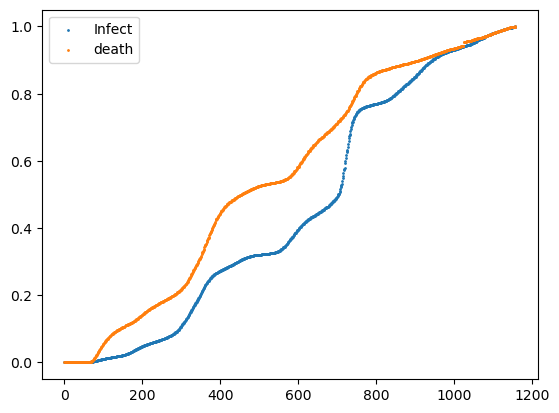

In [295]:
n = len(covid_data["daily_cases"])
x_range = [i for i in range(n)]
plt.scatter(x_range, covid_data["cases"] * (1/np.max(covid_data["cases"])), 1, label="Infect")
plt.scatter(x_range, covid_data["deaths"]* (1/np.max(covid_data["deaths"])), 1, label="death")
plt.legend()

In [303]:
covid_data.iloc[130:150]

,date,cases,deaths,daily_cases,daily_death
130,2020-05-30,1778668,103775,23397.0,963.0
131,2020-05-31,1799302,104379,20634.0,604.0
132,2020-06-01,1821199,105113,21897.0,734.0
133,2020-06-02,1841990,106195,20791.0,1082.0
134,2020-06-03,1861977,107184,19987.0,989.0
135,2020-06-04,1883593,108192,21616.0,1008.0
136,2020-06-05,1912302,109304,28709.0,1112.0
137,2020-06-06,1934818,110032,22516.0,728.0
138,2020-06-07,1953434,110422,18616.0,390.0
139,2020-06-08,1971641,111144,18207.0,722.0


## Regression

In [19]:
from causallearn.graph.GraphNode import GraphNode


In [21]:
GraphNode(1)